In [1]:
import json
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

from simulation import minimal_model as mm
from surrogate import neural_network

from sampling.grid import Grid
from sampling.random import Random
from sampling.lhs import LatinHyperCube, OrtogonalLatinHyperCube
from sampling.greedy_farpoint import GREEDYFP

from visualise import stream, surface

from skgstat import Variogram, OrdinaryKriging

2024-07-03 10:18:52.493791: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 10:18:53.280306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def get_primes(n):
    out = list()
    sieve = [True] * (n+1)
    for p in range(2, n+1):
        if (sieve[p] and sieve[p]%2==1):
            out.append(p)
            for i in range(p, n+1, p):
                sieve[i] = False
    return out

In [3]:
# All sampling methods instances you want to test.
sampling_methods = [Random, Grid, LatinHyperCube, OrtogonalLatinHyperCube, GREEDYFP]

requested_n = 1000
prime = get_primes(int(np.sqrt(requested_n)))[-1]
n_samples = prime**2
print(n_samples)

# Minimal model testing
g = 1.78
B_lim, D_lim = 2.9, 0.4
bounds = [(0, D_lim), (0, B_lim)]

961


In [4]:
# Define the variogram model (simple linear model)
def variogram(x, y):
    return np.linalg.norm(x - y)

# Kriging interpolation function
def kriging_interpolation(points, grid_x, grid_y):
    n = points.shape[0]
    A = np.zeros((n + 1, n + 1))
    b = np.zeros(n + 1)
    
    # Construct the A matrix using variogram values between known points
    for i in range(n):
        for j in range(n):
            A[i, j] = variogram(points[i, :2], points[j, :2])
        A[i, n] = 1  # Adding the constraint
        A[n, i] = 1  # Adding the constraint
    
    A[n, n] = 0  # Regularization term

    Z = points[:, 2]
    
    interpolated_values = np.zeros_like(grid_x)
    
    # Iterate over each grid point
    for gx in range(grid_x.shape[0]):
        for gy in range(grid_x.shape[1]):
            # Construct the b vector using variogram values between grid point and known points
            for i in range(n):
                b[i] = variogram([grid_x[gx, gy], grid_y[gx, gy]], points[i, :2])
            b[n] = 1  # Adding the constraint
            
            # Solve the linear system to get weights
            weights = np.linalg.solve(A, b)
            
            # Calculate the interpolated value using the weights
            interpolated_values[gx, gy] = np.dot(weights[:-1], Z)
    
    return interpolated_values

In [26]:
def create_pdf_from_grid(grid_z, **kwargs):
    # All negatives to positive and invert valus. This will benefit values closer to 0 (equilibrium)
    grid_z = np.abs(grid_z) *  -1

    # Normalize the grid values to create a PDF
    min_val = np.min(grid_z)
    
    # Invert and normalize to make regions near zero have higher probabilities
    inverted_grid_z = min_val - grid_z
    pdf = inverted_grid_z / np.sum(inverted_grid_z)
    # Add negative zero
    return pdf

def create_pdf_from_grid_exp(grid_z, beta=1.0):
    # Ensure grid_z has only non-negative values by taking absolute values
    grid_z = np.abs(grid_z)
    
    # Normalize the grid values to the range [0, 1]
    min_val = np.min(grid_z)
    max_val = np.max(grid_z)
    normalized_grid_z = (grid_z - min_val) / (max_val - min_val)
    
    # Apply the exponential function to emphasize closeness to zero
    exp_grid_z = np.exp(-beta * normalized_grid_z)
    
    # Normalize to create a proper probability density function
    pdf = exp_grid_z / np.sum(exp_grid_z)
    
    return pdf

def scale_min_max(pdf):
    # Normalize the grid values to the range [0, 1]
    min_val = np.min(pdf)
    max_val = np.max(pdf)
    return (pdf - min_val) / (max_val - min_val)


def create_pdf_from_grid_log(grid_z, **kwargs):
    # Ensure grid_z has only non-negative values by taking absolute values
    normalized_grid_z = np.abs(grid_z)
    # normalized_grid_z = scale_min_max(normalized_grid_z)
    
    # Add a small constant to avoid log(0) which is undefined
    normalized_grid_z[normalized_grid_z == 0] += 1e-10
    # normalized_grid_z -= 1e-20
    
    # Apply the logarithmic function to emphasize closeness to zero
    log_grid_z = np.log(normalized_grid_z)
    
    # Invert the values to ensure that values closer to zero have higher probabilities
    inverted_log_grid_z = -log_grid_z
    
    # Apply a power transformation to exaggerate the differences
    scaled_exaggerated_log_grid_z = scale_min_max(inverted_log_grid_z)
    # Create the PDF by normalizing the scaled exaggerated log values to sum to 1
    pdf = scaled_exaggerated_log_grid_z / np.sum(scaled_exaggerated_log_grid_z)
    
    return pdf

# Example run

/home/daviddemmers/anaconda3/envs/ssml/lib/python3.11/site-packages/skgstat/Variogram.py:1715: OptimizeWarning: Covariance of the parameters could not be estimated
  self.cof, self.cov = curve_fit(


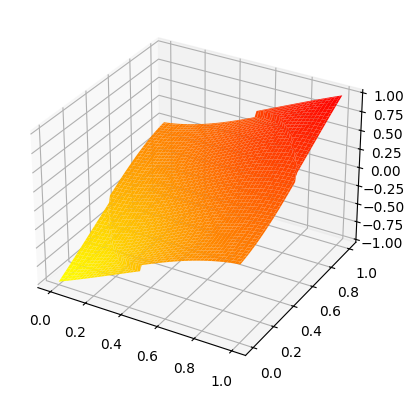

1.0000000000000002


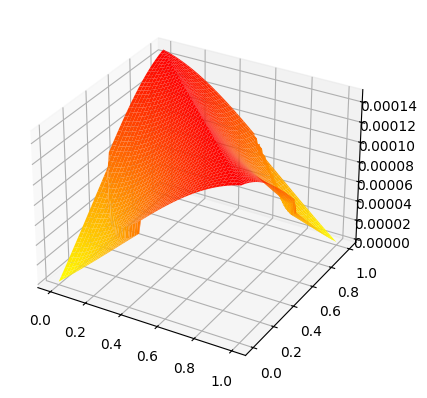

1.0


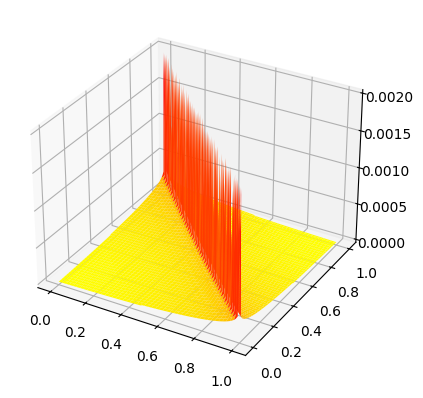

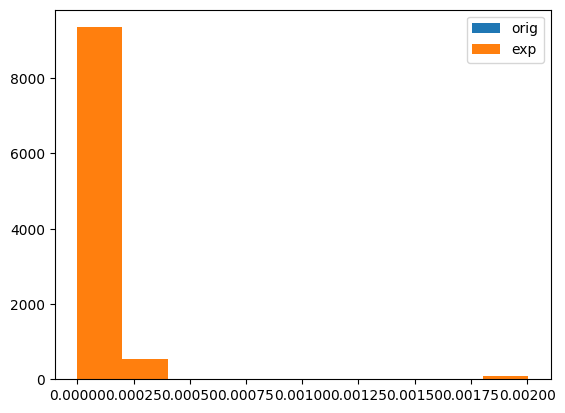

In [6]:
# Sample data points (x, y, z)
straight_slope = np.array([
    [0, 0, -1],
    [0, 1, -1],

    [0.5, 0, 0],
    [0.5, 1, 0],

    [1, 0, 1],
    [1, 1, 1]
])

# Sample data points (x, y, z)
diagonal_slope = np.array([
    [0, 0, -1],
    [0, 1, 0],

    [1, 0, 0],
    [1, 1, 1]
])

test_points = diagonal_slope

# Define grid
B_grid, D_grid = np.mgrid[0:1:100j, 0:1:100j]
V = Variogram(test_points[:,:2], test_points[:,2], n_lags=10, model='spherical', normalize=False)
ok = OrdinaryKriging(V, min_points=1, max_points=50, mode='estimate')
dD_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B_grid, D_grid, dD_dt, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

test_pdf = create_pdf_from_grid(dD_dt)
print(test_pdf.sum())
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B_grid, D_grid, test_pdf, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

test_pdf_exp = create_pdf_from_grid_log(dD_dt)
print(test_pdf_exp.sum())
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(B_grid, D_grid, test_pdf_exp, cmap="autumn_r", lw=1, rstride=2, cstride=2)
plt.show()

plt.hist(test_pdf.flatten(), label='orig')
plt.hist(test_pdf_exp.flatten(), label='exp')
plt.legend()
plt.show()

In [7]:
test_pdf_exp.min()

0.0

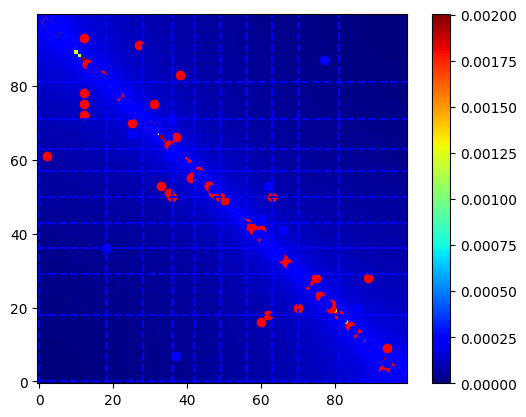

In [8]:
x_random, y_random = Random.sample_stack_pdf(bounds, 100, test_pdf_exp)
x_lhs, y_lhs = Random.sample_stack_pdf(bounds, 100, test_pdf_exp)

# Calculate the scaling factors based on the bounds and the grid dimensions
test_scale = [test_pdf_exp.shape[0] / bounds[0][1], test_pdf_exp.shape[1] / bounds[1][1]]

# B_scale = [1, 1]
# D_scale = [1, 1]

strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(test_pdf_exp, 10)

# Plot vertical lines for strata_indices_x
for x in strata_indices_x:
    plt.axhline(y=x, color='blue', linestyle='--')

# Plot horizontal lines for strata_indices_y
for y in strata_indices_y:
    plt.axvline(x=y, color='blue', linestyle='--')

plt.scatter(x_random * test_scale[0], y_random * test_scale[1], color='red')
plt.scatter(x_lhs * test_scale[0], y_lhs * test_scale[1], color='blue')
plt.imshow(test_pdf_exp, origin='lower', cmap='jet')
plt.colorbar()
plt.show()

# True run

## Generating samples

In [9]:
grid = np.mgrid[0:B_lim:100j, 0:D_lim:100j]
grid.shape

(2, 100, 100)

In [10]:
requested_n = 49
prime = get_primes(int(np.sqrt(requested_n)))[-1]
n_samples = prime**2
print(n_samples)

49


(49,) (49,)


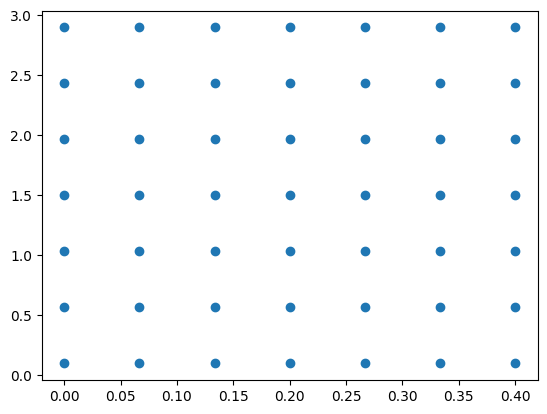

In [11]:
# D_true, B_true = OrtogonalLatinHyperCube.sample_stack([(0, D_lim), (0, B_lim)], n_samples)
D_true, B_true = Grid.sample_stack([(0, D_lim), (1e-1, B_lim)], n_samples)
print(D_true.shape, B_true.shape)
# D_true, B_true = Random.sample_stack([(0, D_lim), (1e-1, B_lim)], n_samples)
# print(D_true.shape, B_true.shape)
plt.scatter(D_true, B_true)
plt.show()
dB_dt, dD_dt = mm.step(B_true, D_true, g, warm_up=0)
dB_dt, dD_dt = dB_dt.reshape((prime,prime)), dD_dt.reshape((prime,prime))

dB_dt[0] = dB_dt[1]

points_B = np.column_stack((B_true.flatten(), D_true.flatten(), dB_dt.flatten()))
points_D = np.column_stack((B_true.flatten(), D_true.flatten(), dD_dt.flatten()))

B_grid, D_grid = np.mgrid[0:B_lim:100j, 0:D_lim:100j]

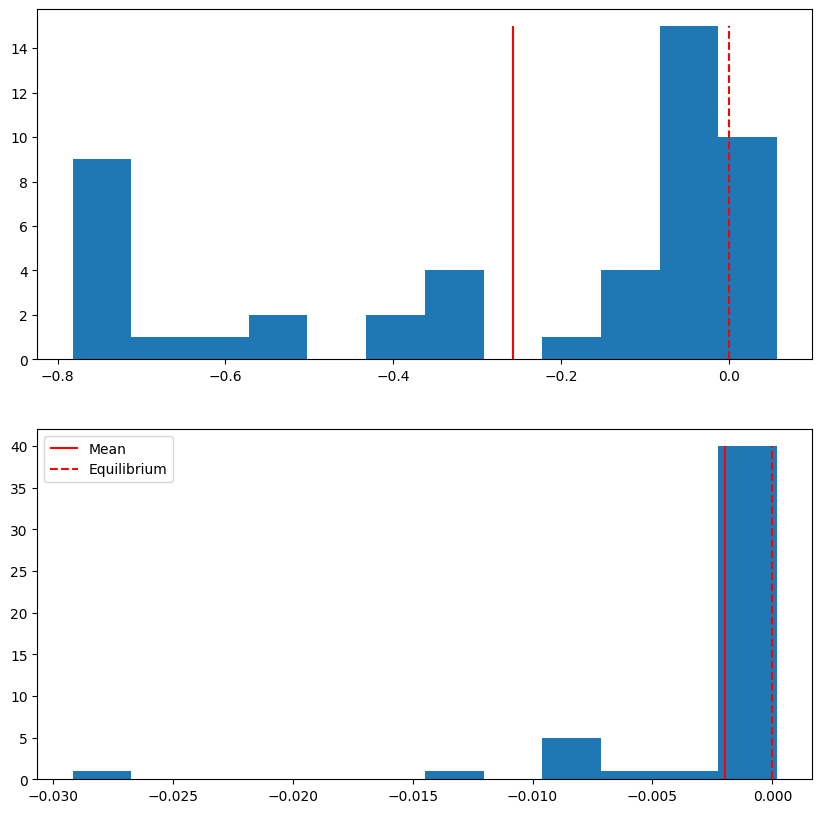

In [12]:
n_bins = 12
fix, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))

n_x, bins_x, _ = ax1.hist(dB_dt.flatten(), n_bins, cumulative=False)
ax1.vlines(dB_dt.mean(), ymin=0, ymax=n_x.max(), colors='red', label="Mean")
ax1.vlines(0, ymin=0, ymax=n_x.max(), colors='red', label="Equilibrium", linestyle='dashed')

n_y, bins_y, _ = ax2.hist(dD_dt.flatten(), n_bins, cumulative=False)
ax2.vlines(dD_dt.mean(), ymin=0, ymax=n_y.max(), colors='red', label="Mean")
ax2.vlines(0, ymin=0, ymax=n_y.max(), colors='red', label="Equilibrium", linestyle='dashed')

plt.legend()
plt.show()

# n, bins, patches = plt.hist(dB_dt.flatten(), equalObs(dB_dt.flatten(), 30), edgecolor='black')
# # plt.xscale('log')
# plt.show()

# n, bins, patches = plt.hist(dD_dt.flatten(), equalObs(dD_dt.flatten(), 30), edgecolor='black')
# plt.xscale('log')
# plt.show()
# sorted(bins)

## Exploitation

### Rate of change - D & B

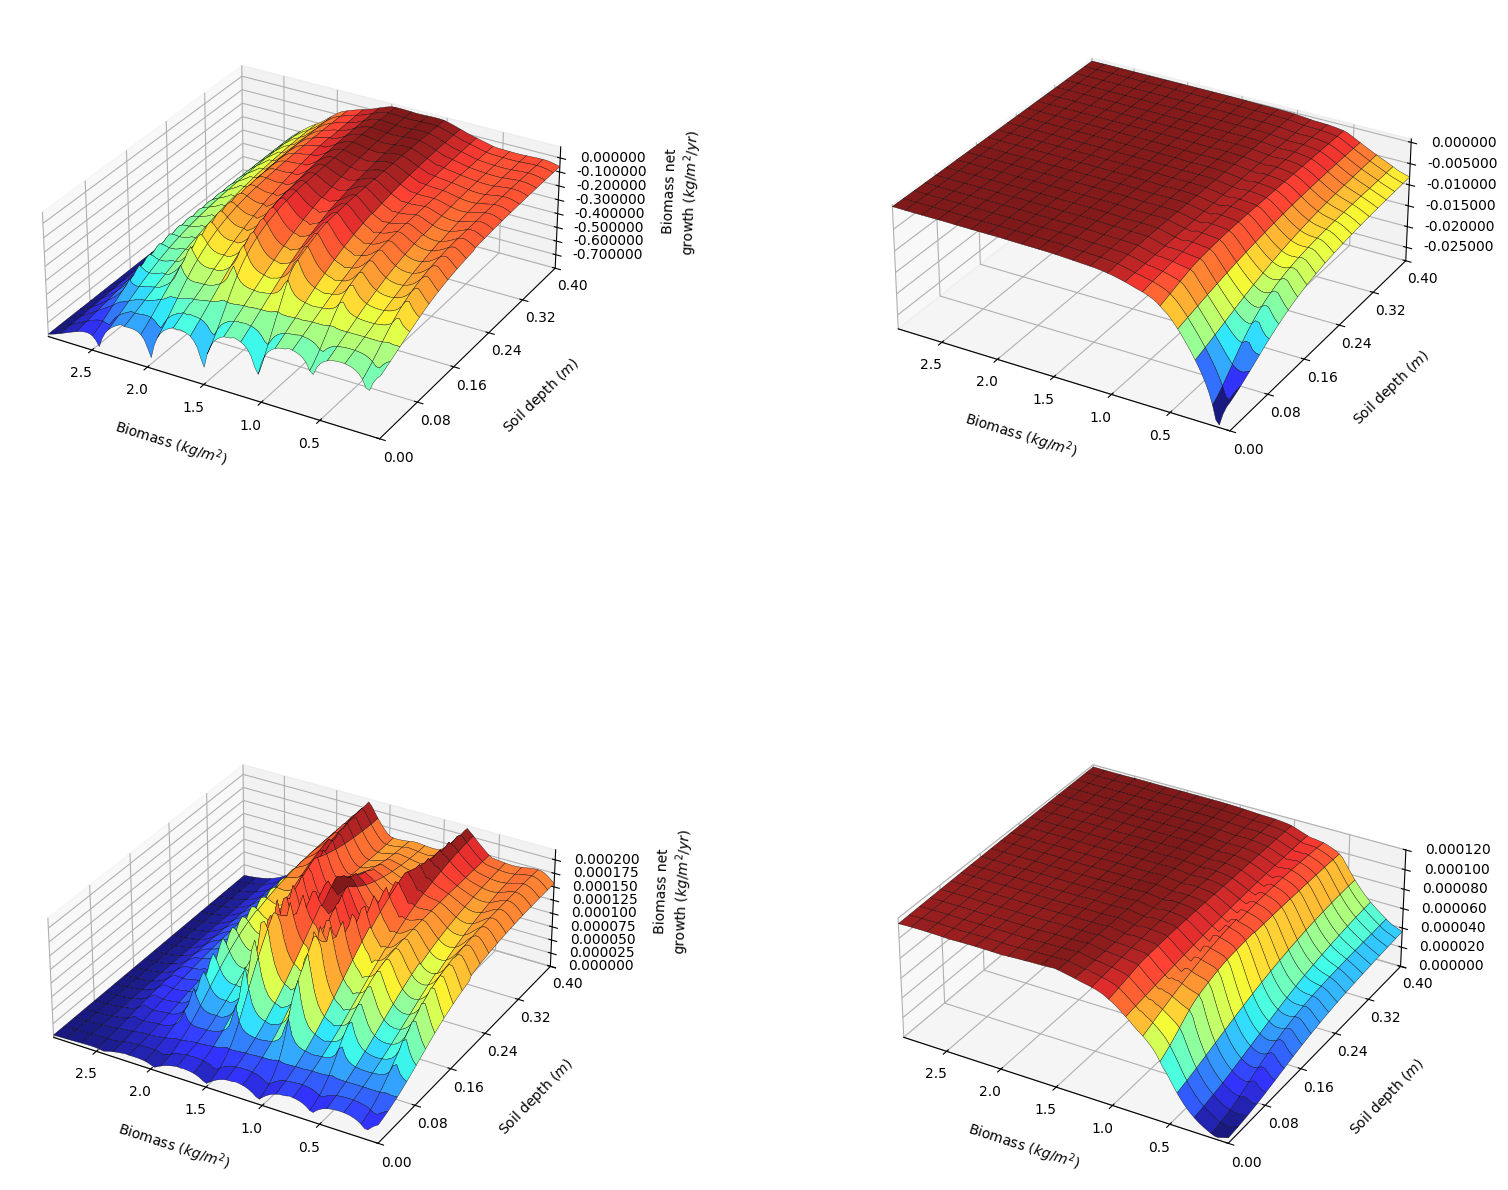

In [18]:
beta = 4
# Define grid
D_vario = Variogram(points_D[:,:2], points_D[:,2], n_lags=20, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(D_vario, min_points=5, max_points=20, mode='exact')
dD_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
# D_pdf = create_pdf_from_grid(dD_dt, beta=beta)
D_pdf = create_pdf_from_grid_exp(dD_dt, beta=beta)

B_vario = Variogram(points_B[:,:2], points_B[:,2], n_lags=20, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(B_vario, min_points=5, max_points=20, mode='exact')
dB_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
# B_pdf = create_pdf_from_grid(dB_dt, beta=beta)
B_pdf = create_pdf_from_grid_exp(dB_dt, beta=beta)

surface.pdf(D_grid, B_grid, dD_dt, dB_dt, D_pdf, B_pdf, D_lim, B_lim)

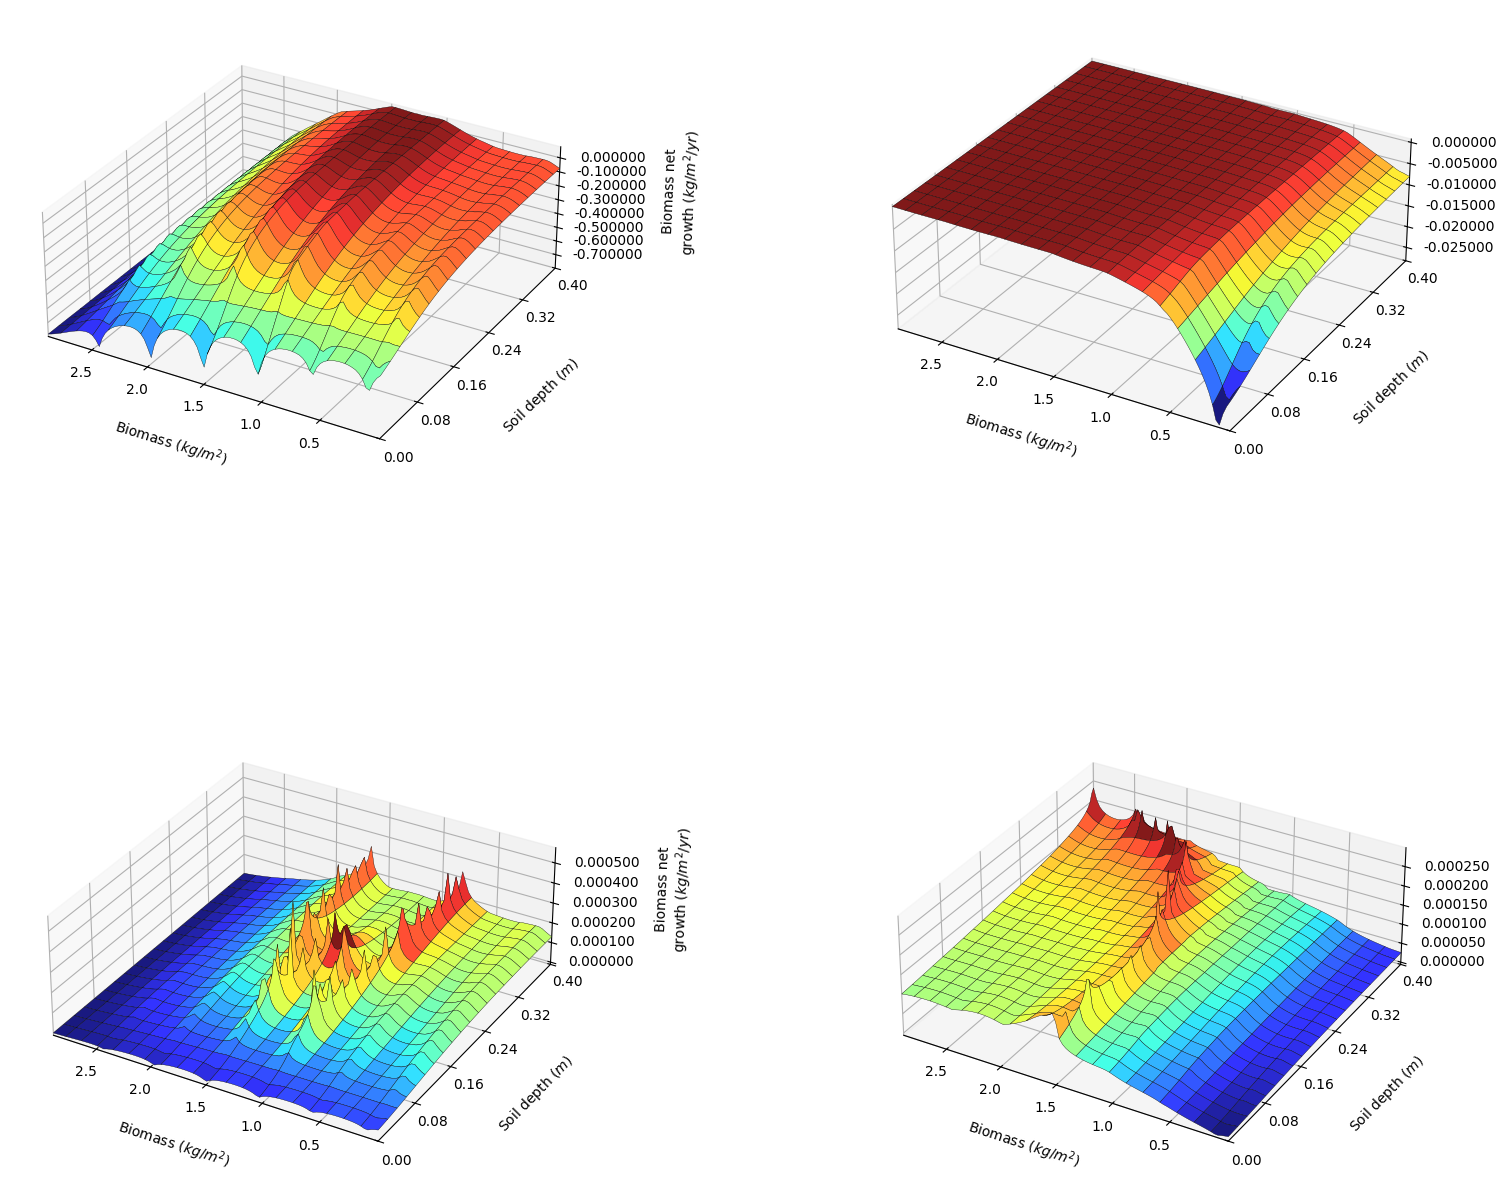

In [21]:
# Define grid
D_vario = Variogram(points_D[:,:2], points_D[:,2], n_lags=40, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(D_vario, min_points=5, max_points=40, mode='exact')
dD_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
# D_pdf = create_pdf_from_grid(dD_dt, beta=beta)

B_vario = Variogram(points_B[:,:2], points_B[:,2], n_lags=40, maxlag=2, model='exponential', normalize=False)
ok = OrdinaryKriging(B_vario, min_points=5, max_points=40, mode='exact')
dB_dt = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)

D_pdf = create_pdf_from_grid_log(dD_dt)
B_pdf = create_pdf_from_grid_log(dB_dt)

surface.pdf(D_grid, B_grid, dD_dt, dB_dt, D_pdf, B_pdf, D_lim, B_lim)

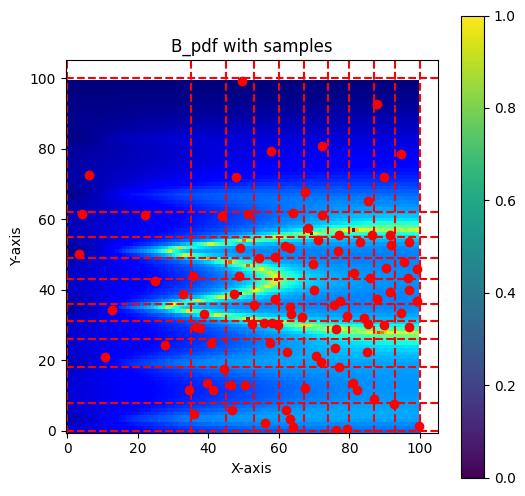

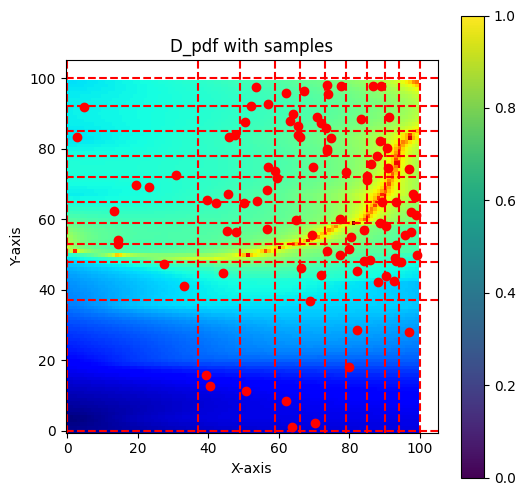

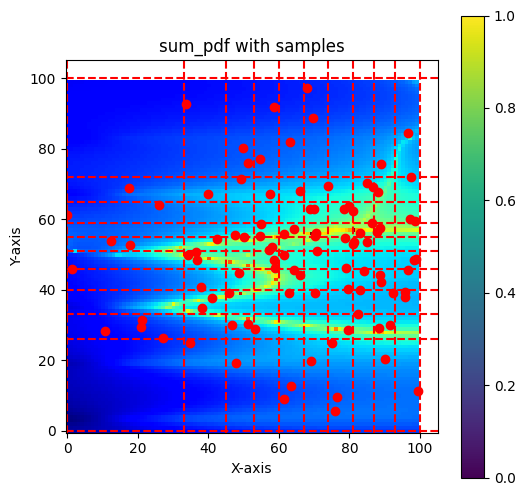

In [24]:
sum_pdf = B_pdf + D_pdf
sum_pdf = sum_pdf / np.sum(sum_pdf)

beta = 2
B_samples = LatinHyperCube.sample_stack_pdf(bounds, 100, B_pdf, beta)
D_samples = LatinHyperCube.sample_stack_pdf(bounds, 100, D_pdf, beta)
sum_samples = LatinHyperCube.sample_stack_pdf(bounds, 100, sum_pdf, beta)

# print(B_samples[0].min(), B_samples[0].max(), B_samples[1].min(), B_samples[1].max())
strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(B_pdf, 10, beta)

# B_samples = Random.random_pdf(bounds, 100, B_pdf)
# D_samples = Random.random_pdf(bounds, 100, D_pdf)

# Calculate the scaling factors based on the bounds and the grid dimensions
scale = [B_pdf.shape[0] / bounds[0][1], B_pdf.shape[1] / bounds[1][1]] 

# Function to plot the PDFs with scaling and stratification
def plot_pdf_with_samples(pdf, samples, scale, strata_indices_x, strata_indices_y, title):
    plt.figure(figsize=(6, 6))
    
    # Plot vertical lines for strata_indices_x
    for x in strata_indices_x:
        plt.axvline(x=x, color='red', linestyle='--')

    # Plot horizontal lines for strata_indices_y
    for y in strata_indices_y:
        plt.axhline(y=y, color='red', linestyle='--')

    plt.imshow(pdf, origin='lower', cmap='jet')
    plt.scatter(samples[0] * scale[0], samples[1] * scale[1], color='red')
    plt.colorbar()
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

# Plot PDFs with samples
plot_pdf_with_samples(B_pdf, B_samples, scale, strata_indices_x, strata_indices_y, 'B_pdf with samples')

strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(D_pdf, 10, beta)
plot_pdf_with_samples(D_pdf, D_samples, scale, strata_indices_x, strata_indices_y, 'D_pdf with samples')

strata_indices_x, strata_indices_y = LatinHyperCube.stratify_pdf(sum_pdf, 10, beta)
plot_pdf_with_samples(sum_pdf, sum_samples, scale, strata_indices_x, strata_indices_y, 'sum_pdf with samples')


0.024000000000000004 0.38800000000000007 0.0 2.204


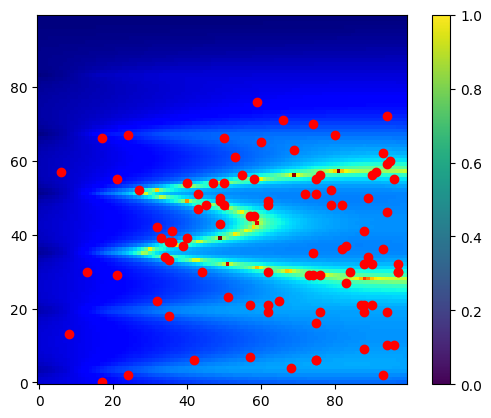

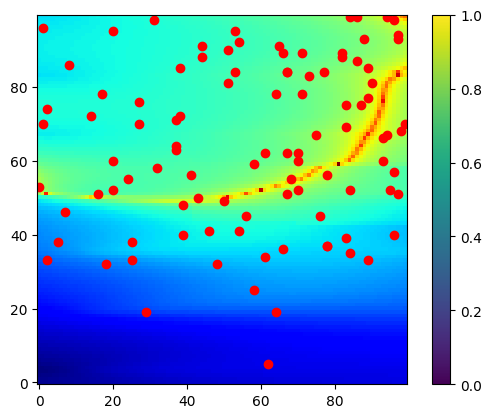

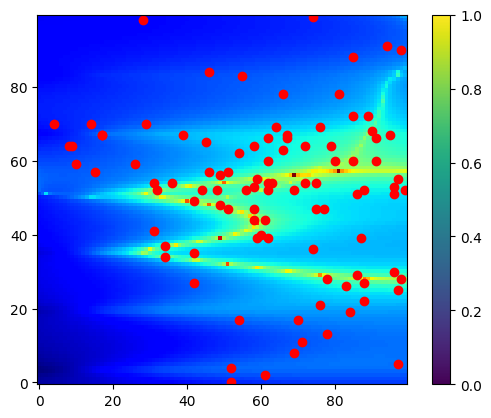

In [25]:
beta = 2
B_samples = Random.sample_stack_pdf(bounds, 100, B_pdf, beta=beta)
D_samples = Random.sample_stack_pdf(bounds, 100, D_pdf, beta=beta)
sum_samples = Random.sample_stack_pdf(bounds, 100, sum_pdf, beta=beta)

print(B_samples[0].min(), B_samples[0].max(), B_samples[1].min(), B_samples[1].max())

# Calculate the scaling factors based on the bounds and the grid dimensions
scale = [D_pdf.shape[0] / bounds[0][1], D_pdf.shape[1] / bounds[1][1]]

# B_scale = [1, 1]
# D_scale = [1, 1]
plt.imshow(B_pdf, origin='lower', cmap='jet')
plt.scatter(B_samples[0] * scale[0], B_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

plt.imshow(D_pdf, origin='lower', cmap='jet')
plt.scatter(D_samples[0] * scale[0], D_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

plt.imshow(sum_pdf, origin='lower', cmap='jet')
plt.scatter(sum_samples[0] * scale[0], sum_samples[1] * scale[1], color='red')
plt.colorbar()
plt.show()

# Exploitation

In [30]:
from tqdm.notebook import tqdm

In [31]:
def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

def exploit(exploration_methods, exploitation_methods, n_requested_samples, ranges, g, hyper_parameters, folds=10, init_beta=4, secondary_beta=2):
    results = pd.DataFrame(columns=[
        'exploration_method', 'exploitation_method',
        'mse_run', 'mse_method', 'mae_run', 'mae_method',
        'hp', 'uid', 'epochs', 'fold'
    ])

    # Converting requested sizes of N to a list of fitting squares of primes.
    req_sqrt = [int(np.sqrt(n)) for n in n_requested_samples]
    primes = [get_primes(sq)[-1] for sq in req_sqrt]
    n_total_samples = np.array([prime**2 for prime in primes])
    n_explore_samples = np.array([tot//2 for tot in n_total_samples])
    n_exploit_samples = n_total_samples - n_explore_samples

    # Interpolation grid for kriging
    B_grid, D_grid = np.mgrid[0:1:100j, 0:1:100j] 

    # Generating seperate run evaluation set. 
    n_eval = 10**4
    D_true, B_true = Random.sample_stack(ranges, n_eval)
    true_dB_dt, true_dD_dt = mm.step(B_true, D_true, g, warm_up=0)
    # The same across all current experiments
    X_test = np.column_stack((B_true.flatten(), D_true.flatten(), np.repeat(g, (n_eval))))
    y_test = np.column_stack((true_dB_dt.flatten(), true_dD_dt.flatten()))

    for method_explore in tqdm(exploration_methods, desc="Explore: ", position=0):
        method_explore_name = str(method_explore.__name__)

        for method_exploit in tqdm(exploitation_methods, desc="Exploit: ", position=1, leave=False):
            exploration_method_name = str(method_exploit.__name__)

            for n_explore, n_exploit in tqdm(list(zip(n_explore_samples, n_exploit_samples)), desc="N: ", position=2, leave=False):
                refresh_max = int(n_explore/10) if int(n_explore/10) > 5 else 5

                # Run the combination N times and retrain per size N
                for fold in range(folds):
                    # print(method_explore, method_exploit, n_explore, n_exploit, n_exploit//2, fold)
                    # Exploration sample.
                    D_points, B_points = method_explore.sample_stack(ranges, n_explore, refresh_count=refresh_max, scale=2)
                    dB_dt_explore, dD_dt_explore = mm.step(B_points, D_points, g)
                    
                    X_explore = np.column_stack([B_points.flatten(), D_points.flatten(), np.repeat(g, (n_explore))])
                    y_explore = np.column_stack([dB_dt_explore.flatten(), dD_dt_explore.flatten()])

                    # Exploitation
                    ## D Kriging
                    D_vario = Variogram(X_explore[:,:2], y_explore[:,0], n_lags=20, maxlag=2, model='exponential', normalize=False)
                    ok = OrdinaryKriging(D_vario, min_points=5, max_points=10, mode='exact')
                    dD_dt_kriging = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
                    D_pdf = create_pdf_from_grid_log(dD_dt_kriging)
                    # D_pdf = create_pdf_from_grid_exp(dD_dt_kriging, init_beta)

                    ## B Kriging
                    B_vario = Variogram(X_explore[:,:2], y_explore[:,1], n_lags=20, maxlag=2, model='exponential', normalize=False)
                    ok = OrdinaryKriging(B_vario, min_points=5, max_points=10, mode='exact')
                    dB_dt_kriging = ok.transform(B_grid.flatten(), D_grid.flatten()).reshape(B_grid.shape)
                    B_pdf = create_pdf_from_grid_log(dB_dt_kriging)
                    # B_pdf = create_pdf_from_grid_exp(dB_dt_kriging, init_beta)

                    # Sample based on both pdf
                    # Currently sample twice from both pdf. Combination can be made of pdf's.
                    D_points_B_pdf, B_points_B_pdf = method_exploit.sample_stack_pdf(ranges, n_exploit//2, B_pdf, beta=secondary_beta)
                    D_points_D_pdf, B_points_D_pdf = method_exploit.sample_stack_pdf(ranges, n_exploit//2, D_pdf, beta=secondary_beta)
                    D_points_exploit, B_points_exploit = np.column_stack([D_points_B_pdf, D_points_D_pdf]), np.column_stack([B_points_B_pdf, B_points_D_pdf])

                    # print(D_points_exploit.shape, B_points_exploit.shape)

                    X_exploit = np.column_stack([D_points_exploit.flatten(), B_points_exploit.flatten(), np.repeat(g, ((n_exploit//2)*2))])
                    # print(X_exploit)
                    dB_dt_exploit, dD_dt_exploit = mm.step(X_exploit[:,0], X_exploit[:,1], g)
                    y_exploit = np.column_stack([dB_dt_exploit.flatten(), dD_dt_exploit.flatten()])

                    # print(X_explore.shape, X_exploit.shape)
                    # print(y_explore.shape, y_exploit.shape)

                    X = np.concatenate([X_explore, X_exploit])
                    y = np.concatenate([y_explore, y_exploit])

                    # print(X.shape, y.shape)

                    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle=True)
                    NN = neural_network.NeuralNetwork(hyper_parameters)
                    NN.train(X_train, y_train, X_val, y_val, verbose=False)

                    y_true_pred = NN.predict(X_test, verbose=False)
                    y_val_pred = NN.predict(X_val, verbose=False)


                    new_row = pd.DataFrame([{
                        'exploration_method': method_explore_name,
                        'exploitation_method': exploration_method_name,
                        'n': n_exploit + n_explore,
                        'mse_run': mean_squared_error(y_test, y_true_pred), # Unseen large random dataset.
                        'mse_method': mean_squared_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                        'mae_run': mean_absolute_error(y_test, y_true_pred), # Unseen large random dataset.
                        'mae_method': mean_absolute_error(y_val, y_val_pred), # Unseen already validated on set from method dataset.
                        'me_run': mean_error(y_test, y_true_pred),
                        'me_method': mean_error(y_val, y_val_pred),
                        'hp': hyper_parameters,
                        'uid': NN.uid,
                        'epochs': len(NN.history.history['loss']),
                        'fold': fold
                    }])
                    results = pd.concat([results, new_row], ignore_index=True)

    results['bias_method'] = (results['me_method']**2) / results['mse_method']
    results['bias_run'] = (results['me_run']**2) / results['mse_run']
    return results

In [29]:
hp = {
    'units': [256, 256, 256, 128, 64],
    'act_fun': 'relu',
    'learning_rate': 0.005,
    'batch_size': 32,
    'l2_reg': 1e-4,
    'n_epochs': 400}

n_requested_samples = [50, 121, 200, 529, 1849]
exploration_methods = [Random, GREEDYFP]
exploitation_methods = [LatinHyperCube, Random]
init_beta, second_beta = 0, 4
results = exploit(exploration_methods, exploitation_methods, n_requested_samples, bounds, g, hp, folds = 10, init_beta=init_beta, secondary_beta=second_beta)

NameError: name 'tqdm' is not defined

In [27]:
# name = datetime.now().strftime('%Y%m%d_%H%M%S')
name = f'2e2_10f_exp_{init_beta}beta{second_beta}_RG_LR'
results.to_csv(f"data/experiments/exploitation/{name}.csv", index_label="index")

In [7]:
def plot_results_seaborn(results, y_axis='mse'):
    translations = {
        'mse': "Mean Squared Error",
        'mae': "Mean Absolute Error"
    }
    axis_text = translations.get(y_axis, y_axis)

    # Create a new figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    # Plot the first lineplot on the first axis
    # sns.lineplot(data=results, x='n', y=f'{y_axis}_run', hue='exploitation_method', marker='o', style="exploration_method", err_style="bars", errorbar=("se"), ax=ax1)
    # sns.lineplot(data=results, x='n', y=f'{y_axis}_run', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax1)
    sns.lineplot(data=results, x='n', y=f'{y_axis}_run', hue='method', style='stage', marker='o', err_style="bars", errorbar=("se"), ax=ax1)
    ax1.set_ylabel(f'{axis_text} (Run)')
    ax1.set_title(f'{y_axis.capitalize()} Run vs Number of Samples for Different Methods')
    if y_axis not in ['bias']: 
        ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f'{x}' for x in xticks])

    # Plot the second lineplot on the second axis
    # sns.lineplot(data=results, x='n', y=f'{y_axis}_method', hue='exploitation_method', marker='o', style="exploration_method", err_style="bars", errorbar=("se"), ax=ax2)
    # sns.lineplot(data=results, x='n', y=f'{y_axis}_method', hue='method', marker='o', err_style="bars", errorbar=("se"), ax=ax2)
    sns.lineplot(data=results, x='n', y=f'{y_axis}_method', hue='method', style='stage', marker='o', err_style="bars", errorbar=("se"), ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel(f'{axis_text} (Method)')
    ax2.set_title(f'{y_axis.capitalize()} Method vs Number of Samples for Different Methods')
    if y_axis not in ['bias']: 
        ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.grid(True)

    # Set the x-ticks to show the exact x-values

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()

In [42]:
prev = "2e2_10f_1beta_RG_LR"
results = pd.read_csv(f"data/experiments/exploitation/{prev}.csv", index_col='index')

prev = "no-seed_6-m_10-fold"
df_10 = pd.read_csv(f"data/experiments/exploration/{prev}.csv", index_col='index')

In [43]:
results['method'] = results['exploration_method'] + '_' + results['exploitation_method']
df_10 = df_10[df_10['n'] > 25]
print(df_10.method.unique())
df_10 = df_10[df_10['method'].isin(['Random', 'GREEDYFP_EQ'])]
df_10['stage'] = 'explore'
results['stage'] = 'explore & exploit'
comb = pd.concat([df_10, results])

['Random' 'Grid' 'Grid_sparse' 'LatinHyperCube' 'OrtogonalLatinHyperCube'
 'GREEDYFP' 'GREEDYFP_EQ']


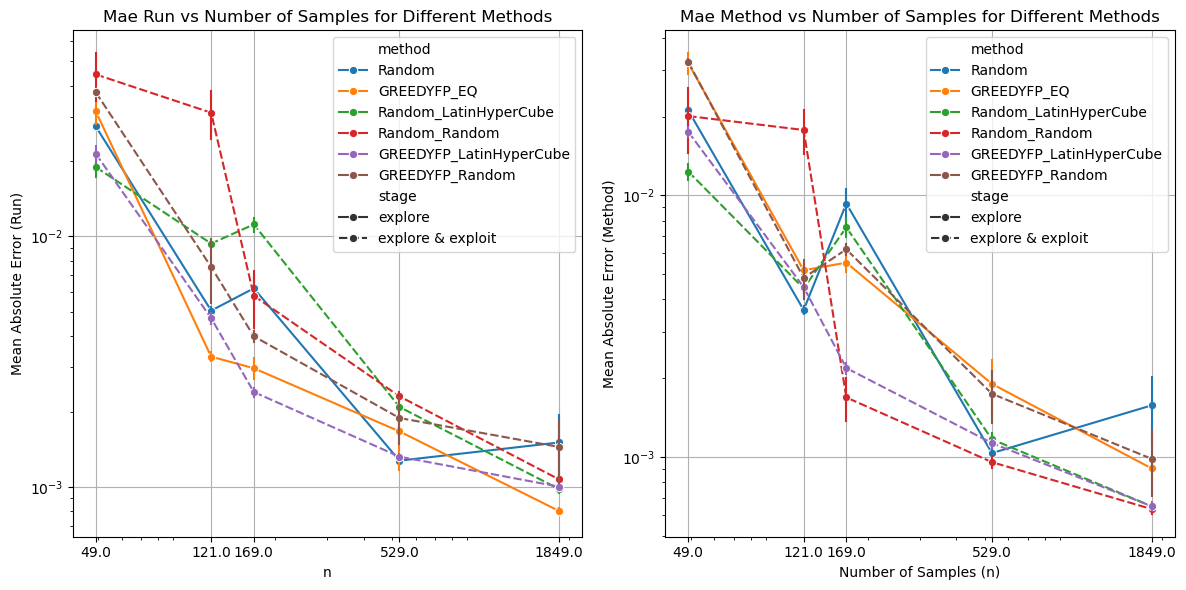

In [44]:
plot_results_seaborn(comb, 'mae')

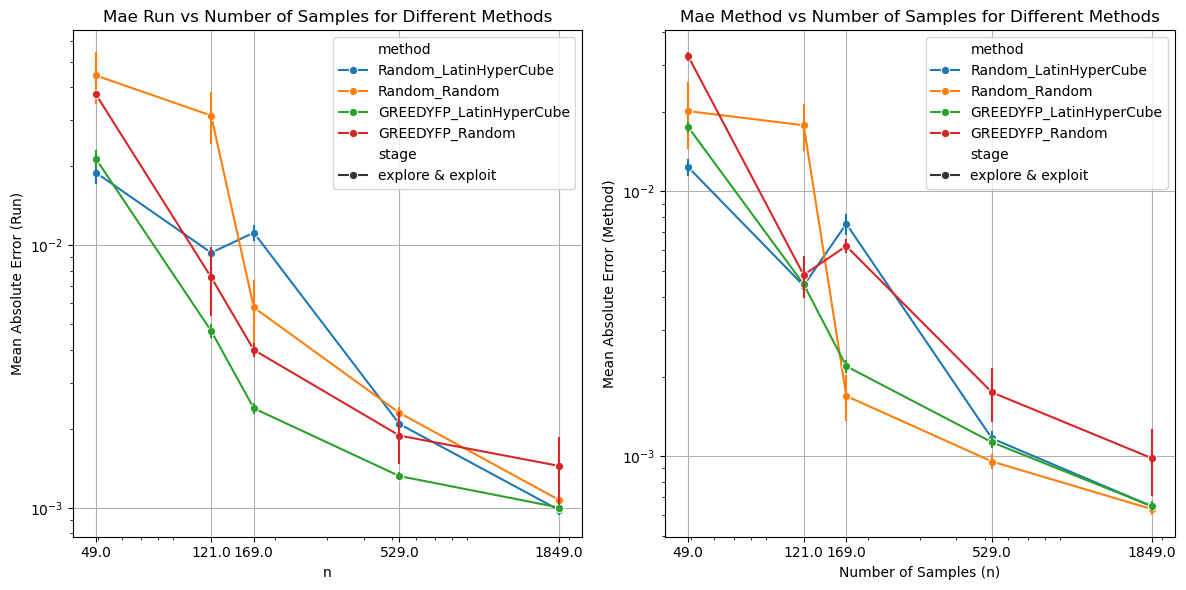

In [45]:
plot_results_seaborn(results, 'mae')

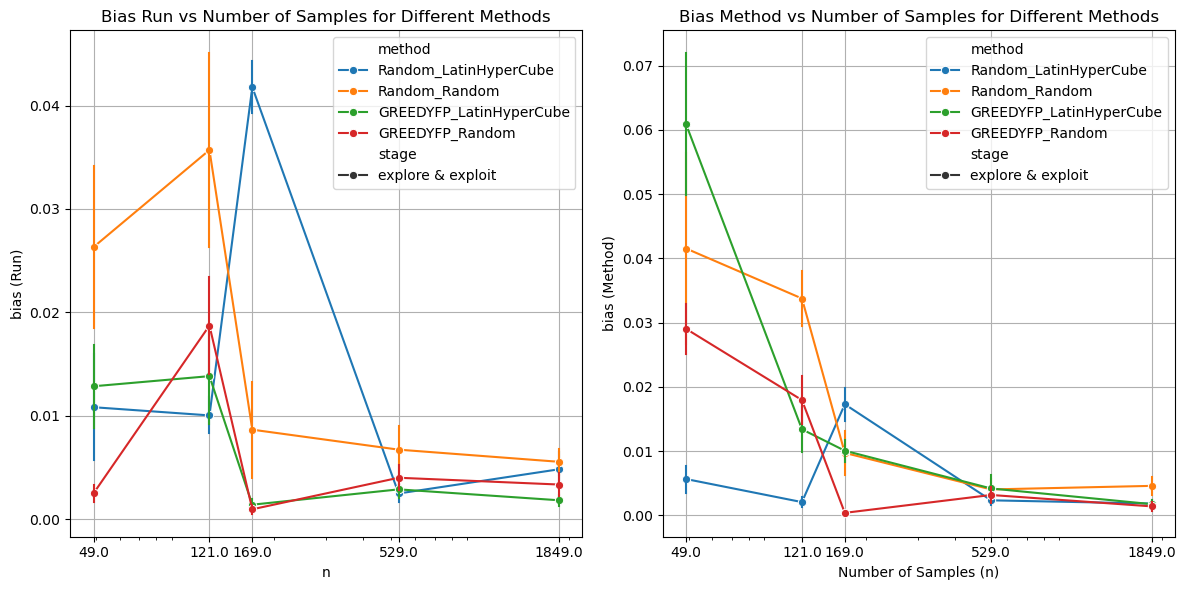

In [46]:
plot_results_seaborn(results, 'bias')

In [13]:
# results.to_csv(f"data/experiments/exploitation/{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv", index_label="index")

,method,n,mse_run,mse_method,mae_run,mae_method,me_run,me_method,hp,uid,...,mae_diff,mse_diff,bias_method,bias_run,experiment,exploration_method,exploitation_method,n_explore,n_exploit,stage
index,,,,,,,,,,,,,,,,,,,,,
10,Random,49.0,0.002796,0.001152,0.022783,0.016252,-0.002119,0.003784,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130159,...,0.006531,0.001644,0.012429,0.001606,exploration,NaN,NaN,NaN,NaN,NaN
11,Random,49.0,0.004580,0.001924,0.027131,0.020092,-0.008965,-0.006505,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130216,...,0.007039,0.002656,0.021992,0.017551,exploration,NaN,NaN,NaN,NaN,NaN
12,Random,49.0,0.005651,0.002457,0.028105,0.022248,-0.010205,-0.005475,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130233,...,0.005856,0.003194,0.012197,0.018429,exploration,NaN,NaN,NaN,NaN,NaN
13,Random,49.0,0.005402,0.002117,0.027555,0.020525,-0.008582,-0.003434,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130250,...,0.007031,0.003285,0.005570,0.013633,exploration,NaN,NaN,NaN,NaN,NaN
14,Random,49.0,0.005827,0.002590,0.028325,0.022700,-0.012735,-0.008205,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240626_130307,...,0.005625,0.003237,0.025992,0.027833,exploration,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,GREEDYFP,1849.0,0.000003,0.000002,0.000867,0.000573,-0.000023,-0.000026,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_162911,...,NaN,NaN,0.000371,0.000165,exploitation,GREEDYFP,Random,NaN,NaN,explore & exploit
196,GREEDYFP,1849.0,0.000005,0.000003,0.001059,0.000663,-0.000055,0.000033,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_163020,...,NaN,NaN,0.000357,0.000658,exploitation,GREEDYFP,Random,NaN,NaN,explore & exploit
197,GREEDYFP,1849.0,0.000004,0.000002,0.000914,0.000581,0.000033,-0.000029,"{'units': [256, 256, 256, 128, 64], 'act_fun':...",20240627_163127,...,NaN,NaN,0.000364,0.000293,exploitation,GREEDYFP,Random,NaN,NaN,explore & exploit


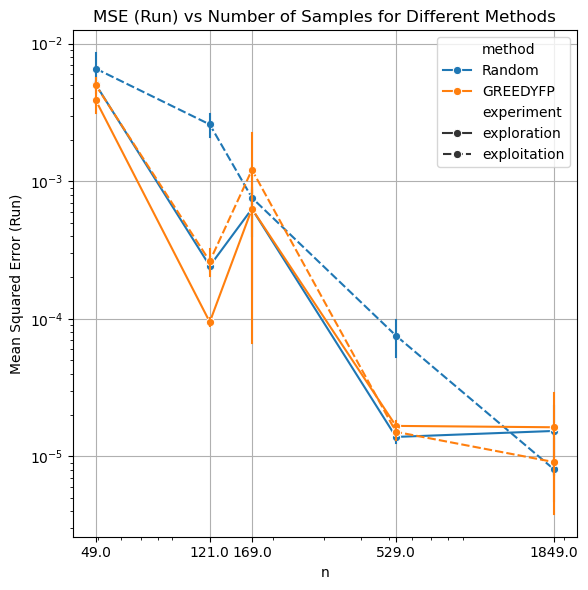

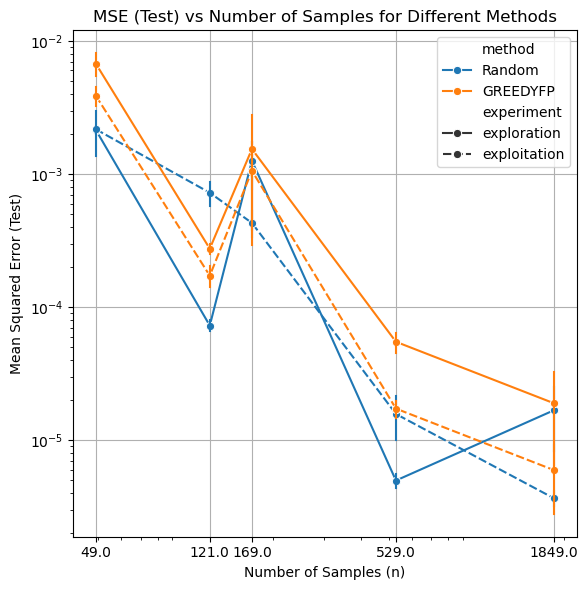

In [14]:
def plot_diff(results):
    # Create a new figure with two subplots
    fig, ax1 = plt.subplots(1, 1, figsize=(6,6), sharex=True)
    # Plot the first lineplot on the first axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax1)
    sns.lineplot(data=results, x='n', y='mse_run', hue='method', marker='o', style="experiment", err_style="bars", errorbar=("se"), ax=ax1)
    ax1.set_ylabel('Mean Squared Error (Run)')
    ax1.set_title('MSE (Run) vs Number of Samples for Different Methods')
    ax1.set_yscale('log')
    ax1.set_xscale('log')
    ax1.grid(True)

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()

    fig, ax2 = plt.subplots(1, 1, figsize=(6,6))

    # Plot the second lineplot on the second axis
    # sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', ax=ax2)
    sns.lineplot(data=results, x='n', y='mse_method', hue='method', marker='o', style="experiment", err_style="bars", errorbar=("se"), ax=ax2)
    ax2.set_xlabel('Number of Samples (n)')
    ax2.set_ylabel('Mean Squared Error (Test)')
    ax2.set_title('MSE (Test) vs Number of Samples for Different Methods')
    ax2.set_yscale('log')
    ax2.set_xscale('log')
    ax2.grid(True)

    # Set the x-ticks to show the exact x-values

    xticks = sorted(results['n'].unique())
    # xticks = np.concatenate([[0], xticks])
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([f'{x}' for x in xticks])
    plt.tight_layout()

    # Show the plot
    plt.show()

prev = "no-seed_6-m_10-fold"
df_10 = pd.read_csv(f"data/experiments/exploration/{prev}.csv", index_col='index')

results['experiment'] = 'exploitation'
results['method'] = results['exploration_method']
df_10['experiment'] = 'exploration'
df_10 = df_10[df_10['n'] > 25]
df_10 = df_10[df_10['method'].isin(['Random', 'GREEDYFP'])]
df_10
combine = pd.concat([df_10, results])
display(combine)
plot_diff(combine)

In [15]:
# exploration_agg.reset_index().join(exploitation_agg.reset_index(), rsuffix='_exploit').reset_index()